# Project 2

The group project is split into 5 tasks. I've already finished the first one, which consists of creating some example pictures of cut out words manually. I've put these examplewords into the folder perpared_words and load them into the variable prepared_words_images so they can be used for the other tasks.

All the tasks are built up in such a way, that nobody has to wait on the other people to finish their task. (Except for the last part of task 4)

## Task 0: Creating and loading testimages
Create some test images and load them here so they can be used for task 1 and 2

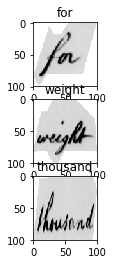

In [1]:
import numpy as np
import os

from PIL import Image
def load_images(data_root, image_paths, target_size):
    images = []
    for img_path in image_paths:
        path = os.path.join(data_root, img_path)
        img = Image.open(path)
        img = img.convert('RGB')
        img = img.resize(target_size)
        images.append(np.array(img)) 
    return images

prepared_words_dir = 'prepared_words'
prepared_words_paths = os.listdir(prepared_words_dir)

target_size = (100, 100)

prepared_words_images = load_images(prepared_words_dir, prepared_words_paths, target_size)
prepared_words_dataset = []
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(len(prepared_words_images)):
    prepared_words_dataset.append((prepared_words_images[i], prepared_words_paths[i][:-4]))
    plt.subplot(3, 1, i+1)
    plt.imshow(prepared_words_dataset[i][0])
    plt.title(prepared_words_dataset[i][1])
    

## Task 1: Dynamic Time Warping
Create a method that calculates the distance between two words using Dynamic Time Wrapping. You can use the words in prepared_words_images for testing your method.

In [2]:
import random
from dtw import dtw
import numpy
import cv2 
import matplotlib.pyplot as plt

euclidean = lambda img1, img2 : numpy.sqrt(numpy.sum((img1-img2)**2))

def dynamic_time_wrapping(img1, img2):
    
    img1 = img1 * 255.0/float(img1.max())
    img2 = img2 * 255.0/float(img2.max())
    dist, cost, acc_cost, path = dtw(img1, img2, dist=euclidean)
    return dist, cost, acc_cost, path


img1 = prepared_words_images[0]
img2 = prepared_words_images[1]

dynamic_time_wrapping(img1, img2)

(509.26381556984416,
 array([[337.98076868, 457.14330357, 471.14647404, ..., 442.4601677 ,
         440.86732698, 426.45398345],
        [385.16619789, 489.21161066, 501.14369197, ..., 492.39922827,
         490.96843076, 478.0679868 ],
        [383.04960514, 484.12601665, 496.16227184, ..., 493.78639106,
         492.35962466, 479.49661104],
        ...,
        [237.01898658, 410.18898084, 432.68002034, ..., 242.01652836,
         239.09203249, 211.33859089],
        [232.9334669 , 407.84188113, 430.45557262, ..., 238.01680613,
         235.04254934, 206.74622125],
        [216.38853944, 398.62388288, 421.73214248, ..., 221.85130155,
         218.65726606, 187.90955271]]),
 array([[   337.98076868,    795.12407225,   1266.27054629, ...,
         100276.49620503, 100717.36353201, 101143.81751546],
        [   723.14696658,    827.19237934,   1296.26776422, ...,
          99765.67170956, 100256.64014032, 100734.70812711],
        [  1106.19657172,   1207.27298323,   1323.35465118, ...,

## Task 2: Train and Apply
Write a Class that can be fed multiple pictures. It should then be able to classify a new picture using the dynamicTimeWrapping method above. You can already use the current dynamicTimeWrapping function (which currently just returns random results).
You can use the words in prepared_words_images for testing your class.

In [3]:
class WordClassifier:
    def __init__(self):
        print("initialized classifier")
        self.words_arr = []
                
    def train(self, words):
        print('training the model')
        # normalize the model and save to the array
        for i in range(len(words)):
            new_word = cv2.resize(words[i][1], dsize=target_size, interpolation=cv2.INTER_CUBIC)
            self.words_arr.append((words[i][0], new_word, words[i][2]))
        print('Size of a train array {}'.format(len(self.words_arr)))
        
    # should return the label of the c
    def classify(self, word):
        words_scores = {}
        # Classify a word
        print('classifying a word')
        for i in range(len(self.words_arr)):
            resized_word = cv2.resize(word, dsize=target_size, interpolation=cv2.INTER_CUBIC)
            word_from_arr = self.words_arr[i][1]
            min_dist, cost_mtx, acc_cost_matx, warp_path = dynamic_time_wrapping(word_from_arr, resized_word)
            words_scores[(self.words_arr[i][0], self.words_arr[i][2])] = min_dist
            
        sorted_res = sorted(words_scores.items(), key=lambda kv: kv[1])
        
        # this computes the minimal word in the list
        minimal_word_id = min(words_scores, key=words_scores.get) 
        return minimal_word_id, sorted_res

## Task 3: Split up the jpg pages into individual pictures of words
Write an algorithm that turns a given page in the images folder into pictures of individual words using the svg file from the ground-truth folder. Currently it just returns the words from prepared_words_images so the people from the other tasks can already use it.

In [4]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 # library needs to be installed first: conda install -c conda-forge opencv

# Take a page number as input
# Return an array with the corresponding Id as the first argument 
# and the cropped image(word with white background) as numpy array as the second argument
# e.g. [['70-01-01', array([[255, 255, 255, ..., 207, 207, 206],
#                           [255, 255, 255, ..., 208, 208, 255],
#                           [255, 255, 255, ..., 207, 208, 255],
#                           ...,
#                           [255, 255, 255, ..., 255, 255, 255],
#                           [255, 255, 255, ..., 255, 255, 255],
#                           [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)],
#       ... ]
def loadWordsFromPage(page_number):
    path_ground_truth = "ground-truth/locations/" + str(page_number) + ".svg"
    path_image = "images/" + str(page_number) + ".jpg"
    path_transcription = "ground-truth/transcription.txt"
    keywords_path = 'task/keywords.txt'
    
    allCoordinates = []
    
    with open(path_ground_truth, "r") as paths:
        for line in paths :
            coordinates = []
            if "path" in line :
                startIndexCoordinate = line.find("M") + 1
                endIndexCoordinate = line.find("Z")

                startIndexId = line.find("id=") + 4
                endIndexId = startIndexId + 9

                substringCoordinates = line[startIndexCoordinate: endIndexCoordinate]
                coordinateStrings = re.findall("\d+\.\d+", substringCoordinates)

                substringId = line[startIndexId: endIndexId]

                index = 0
                for i in range(int(len(coordinateStrings)/2)):
                    coordinates.append([float(coordinateStrings[index]), float(coordinateStrings[index+1])])
                    index += 2   
                allCoordinates.append([substringId, coordinates])  
    
    transcriptions = {}
    keywords = []
    
    with open(path_transcription, "r") as lines:
        for line in lines :
            transcriptions[line[0:9]] = line[10:len(line)-1]
    
    with open(path_transcription, "r") as lines:
        for line in lines :
            keywords.append(line[10:len(line)-1])
    
    
    prepared_words_images = []
    
    img = Image.open(path_image)
    img = np.array(img)
    
    for wordCoordinates in allCoordinates:
        if(transcriptions[wordCoordinates[0]] in keywords):
            clone = img.copy() 

            contours = [np.array(wordCoordinates[1], dtype=np.int32)]
            mask = np.ones_like(clone)*255
            cv2.drawContours(mask,contours,0,0,-1)
            out = np.ones_like(clone)*255
            out[mask == 0] = clone[mask == 0]

            (x, y) = np.where(mask == 0)
            (topx, topy) = (np.min(x), np.min(y))
            (bottomx, bottomy) = (np.max(x), np.max(y))
            out = out[topx:bottomx+1, topy:bottomy+1]
            out[out>170] = 255
            prepared_words_images.append([wordCoordinates[0], out, transcriptions[wordCoordinates[0]]])

    return prepared_words_images

In [5]:
prepared_words = loadWordsFromPage(270)

(91, 188)
<class 'numpy.ndarray'>
['270-01-01', array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 's_2-s_7-s_0-s_pt']
(106, 274)
<class 'numpy.ndarray'>
['270-01-02', array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'L-e-t-t-e-r-s-s_cm']
(96, 278)
<class 'numpy.ndarray'>
['270-01-03', array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],

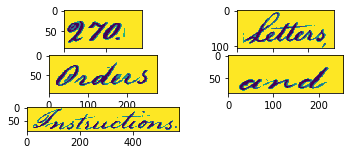

In [6]:
for i in range(5):
    print(prepared_words[i][1].shape)
    print(type(prepared_words[i][1]))
    plt.subplot(5,2,i+1)
    plt.imshow(prepared_words[i][1])
    print(prepared_words[i])

In [7]:
dynamic_time_wrapping(prepared_words[0][1],prepared_words[0][1])

from skimage import data
from skimage.color import rgb2gray
# print(prepared_words_dataset[1][0])

classifier = WordClassifier()
classifier.train(prepared_words)

# this works
results = classifier.classify(prepared_words[5][1])
print(results[0])

initialized classifier
training the model
Size of a train array 221
classifying a word
('270-01-06', 'O-c-t-o-b-e-r')


## Task 4:  Combine all above tasks
Use the class and methods above to train and apply our classifier. Maybe write something about accuracy and stuff once the other people have finished their part. Check the exercise hour pdf and https://github.com/lunactic/PatRec17_KWS_Data for more info.

In [8]:
import string
train_path = 'task/train.txt'
val_path = 'task/valid.txt'
keywords_path = 'task/keywords.txt'

def read_pages_numbers(directory):
    f = open(directory, 'r')
    x = f.readlines()
    pages = [w.replace('\n', '') for w in x] # replace trailing sign of new line end of the string
    f.close()
    return pages

# Given an input path this returns an array containing arrays of cropped words:
# Cropped words:
#     An array with the corresponding Id as the first argument 
#     and the cropped image(word with white background) as numpy array as the second argument
def load_data(path):
    pages = read_pages_numbers(path)
    keywords = read_pages_numbers(keywords_path)
    images = []
    for i in range(len(pages)):
        pagenum = (int)(pages[i])
        print('Loading images from page', pagenum)
        for word in loadWordsFromPage(pagenum):
            if word[2] in keywords:
                images.append(word)
    print('length is ' + str(len(images)))
    print("---------------------------------------")
    return images

train_images = load_data(train_path)
val_images = load_data(val_path)

Loading images from page 270
Loading images from page 271
Loading images from page 272
Loading images from page 273
Loading images from page 274
Loading images from page 275
Loading images from page 276
Loading images from page 277
Loading images from page 278
Loading images from page 279
length is 325
---------------------------------------
Loading images from page 300
Loading images from page 301
Loading images from page 302
Loading images from page 303
Loading images from page 304
length is 70
---------------------------------------


In [9]:
def train_a_classifier(path):
    classifier = WordClassifier()
    classifier.train(train_images)
    return classifier


def classify_images(classifier, images):
    results = []
    correct = 0
    wrong = 0
    for image in images:
        result = classifier.classify(image[1])
        results.append(result)
        print("Was " + str(image[2]) + " and got " + str(result[0][1]))
        if (str(image[2]) == str(result[0][1])):
            correct = correct + 1
        else:
            wrong = wrong + 1
    return results, correct, wrong


def calculate_accuracy(correct, wrong):
    accuracy = correct /(correct + wrong) 
    return accuracy


def calculate_accuracy(prediction, test_label):
    # compare prediction with test labels get array with true and false and count number of trues
    correct = np.count_nonzero(prediction == test_label)
    return correct / test_label.shape[0]
        

def main():
    # train a  word classifier with images given in the train directory
    classifier = train_a_classifier(train_path)
    # classify
    results, correct, wrong = classify_images(classifier, val_images)
    # Check against ground truth: Is the label taken the same as in the ground truth?
    # From the obtained results, calculate statistics
    accuracy = calculate_accuracy(correct, wrong)
    print(accuracy)

main()

initialized classifier
training the model
Size of a train array 325
classifying a word
Was O-r-d-e-r-s and got O-r-d-e-r-s
classifying a word
Was I-n-s-t-r-u-c-t-i-o-n-s-s_pt and got I-n-s-t-r-u-c-t-i-o-n-s-s_pt
classifying a word


KeyboardInterrupt: 